###0. Imports and drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install anndata
import anndata as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn import preprocessing
from IPython.display import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.7 MB/s 


###1. Exploration
In this Task it will be helpful to use anndata. It is a package used to operate on
.h5ad objects that is commonly used in scRNA-seq analysis. Quick tutorial here.
We will be dealing with sparse matrices, but you can always cast it to dense (watch
out for OOM) using the method sparsematrix.toarray().

(a) (1 pt.) Load your dataset using adata = sc.read h5ad(path) and report how
many observations and variables the loaded training and test data sets contain.

In [3]:
train_adata = sc.read_h5ad("/content/drive/My Drive/project 1/SAD2022Z_Project1_GEX_train.h5ad")
test_adata = sc.read_h5ad("/content/drive/My Drive/project 1/SAD2022Z_Project1_GEX_test.h5ad")
print(train_adata)
print(test_adata)

AnnData object with n_obs × n_vars = 72208 × 5000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    layers: 'counts'
AnnData object with n_obs × n_vars = 18052 × 5000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'Donor

In train dataset we have 72208 observations with 5000 variables and the test dataset we have 18052 observations with 5000 variables.

(b) (3 pt.) Access the adata.X object, which contains a matrix of counts which has
been already preprocessed, and the adata.layers[’counts’] object, which
contains raw data. Plot histograms of both the raw data and the processed
data. Pay attention to the X-axis and the range of values spanned by the data.

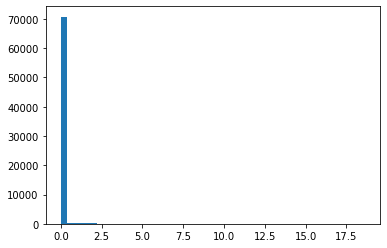

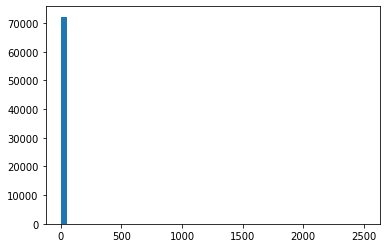

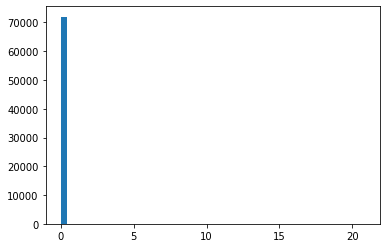

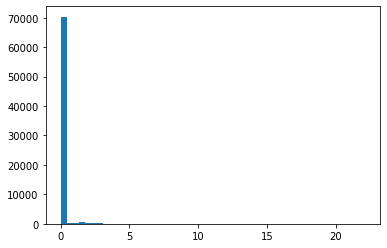

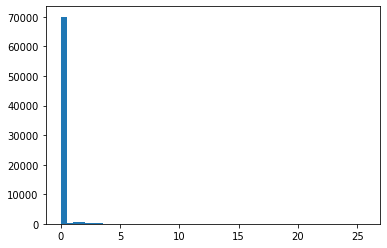

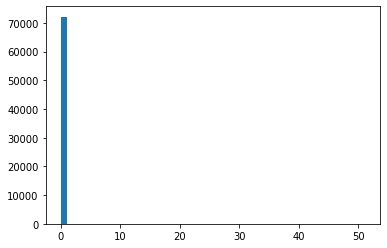

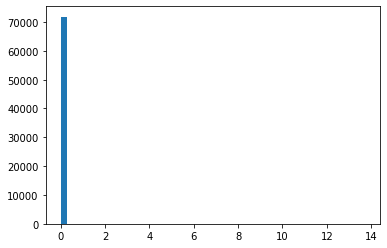

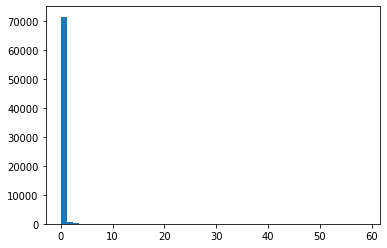

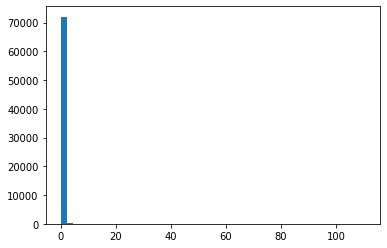

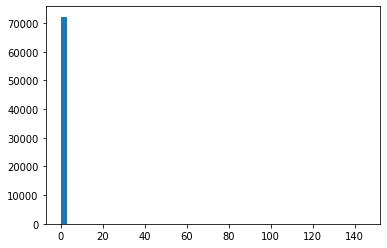

In [4]:
raw_train = train_adata.X.toarray()
raw_train_df = pd.DataFrame(raw_train)
for i in range(10):
  plt.hist(raw_train_df[i],bins = 50)
  plt.show()

Plotting the histograms of the first 10 genes from the raw dataset, we see most occurrences are close to 0 but a minority has values greater. For the first 10 genes, the max value is between 20 and 2500.

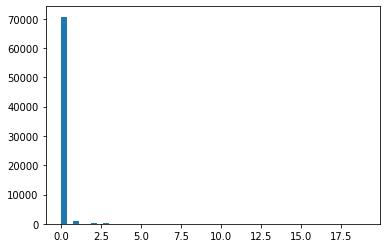

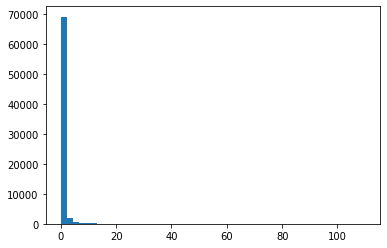

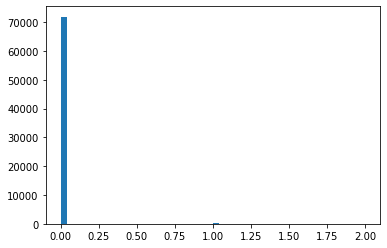

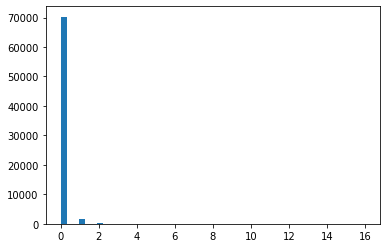

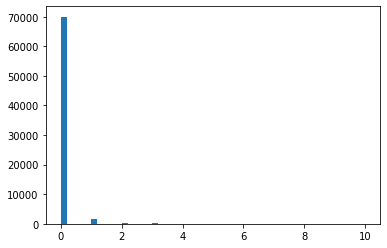

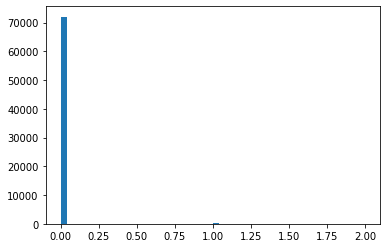

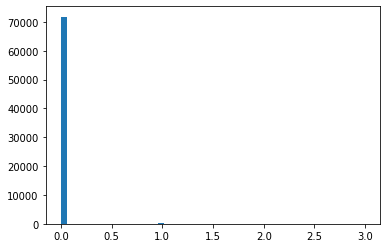

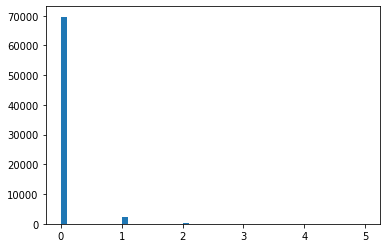

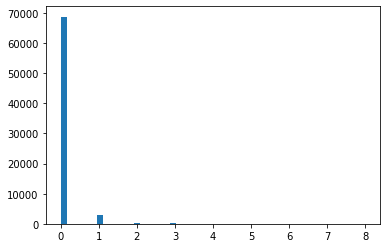

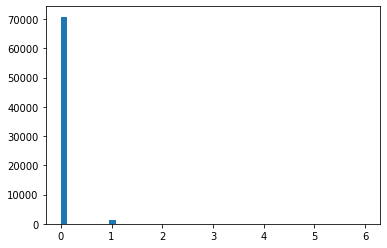

In [5]:
preprocessed_train = train_adata.layers['counts'].toarray()
preprocessed_train_df = pd.DataFrame(preprocessed_train)
for i in range(10):
  plt.hist(preprocessed_train_df[i],bins = 50)
  plt.show()

Plotting the histograms of the first 10 genes from the preprocessed dataset, we see the occurrences have been quantified and normalized, so the max value for the first 10 genes, is much lower than the raw dataset.

(c) (4 pt.) Explain what kind of preprocessing has been applied to the preprocessed
matrix. Tip: You can also check min, max, mean, etc.

We will take a look to some genes to find out the transformations used.

In [6]:
for i in range(10):
  print("Preprocessed data")
  print(preprocessed_train_df[i].describe())
  print("Raw data")
  print(raw_train_df[i].describe())
  print("------------------------")

Preprocessed data
count    72208.000000
mean         0.039262
std          0.344583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         19.000000
Name: 0, dtype: float64
Raw data
count    72208.000000
mean         0.036447
std          0.329053
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.642887
Name: 0, dtype: float64
------------------------
Preprocessed data
count    72208.000000
mean         0.523917
std          1.590549
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        110.000000
Name: 1, dtype: float64
Raw data
count    72208.000000
mean         0.678159
std         10.657404
min          0.000000
25%          0.000000
50%          0.000000
75%          0.628168
max       2512.345703
Name: 1, dtype: float64
------------------------
Preprocessed data
count    72208.000000
mean         0.004778
std          0.071327
min         

We observe, data has been approximated to integer precision and also normalized, reducing the maximum values without modifying a lot the mean distribution. This can be achieved since the count of 'high' values are rare.

(d) (3 pt.) Remove zeroes from both the raw and the processed matrices. Plot
histograms of both modified data sets.

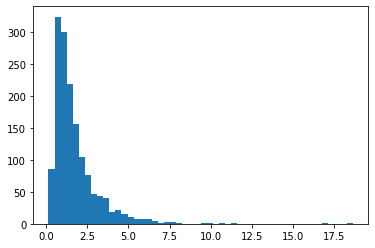

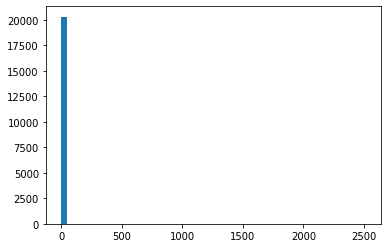

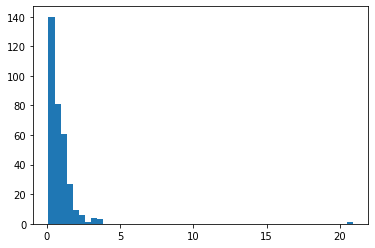

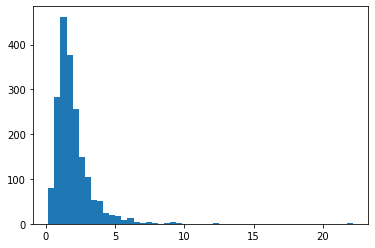

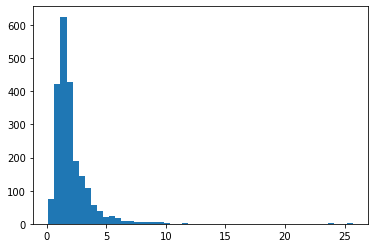

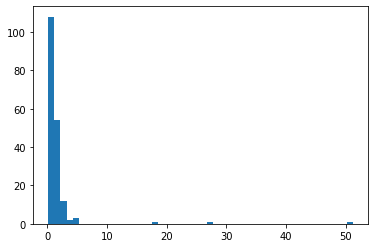

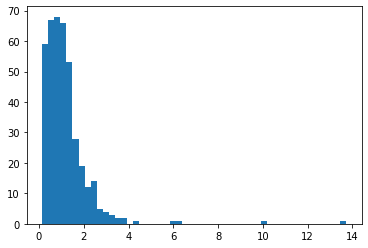

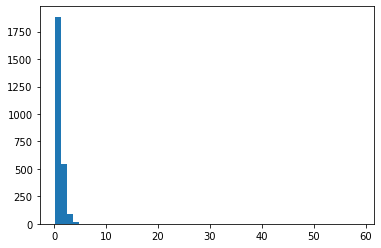

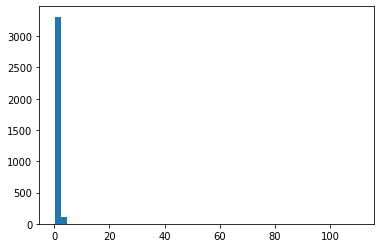

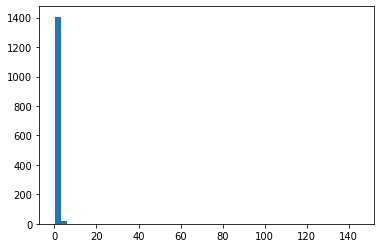

In [7]:
for i in range(10):
  plt.hist(raw_train_df[i][raw_train_df[i]!= 0],bins = 50)
  plt.show()

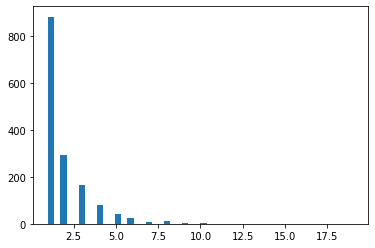

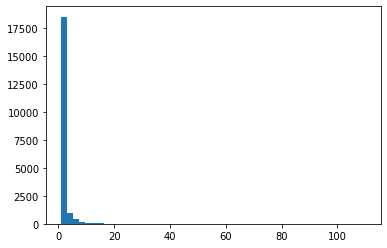

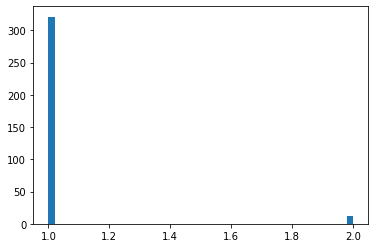

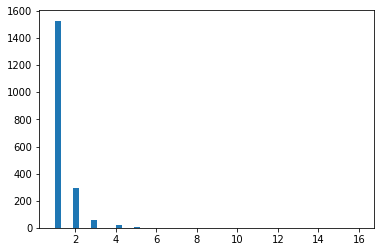

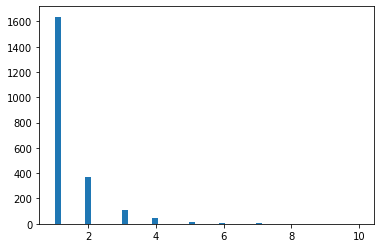

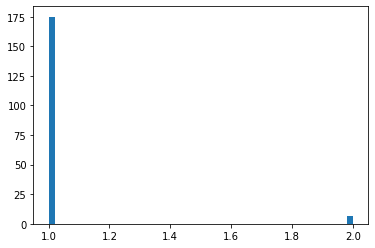

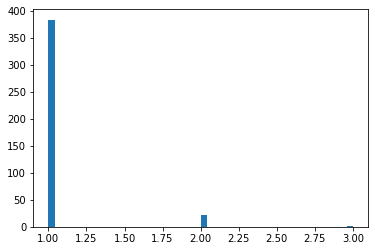

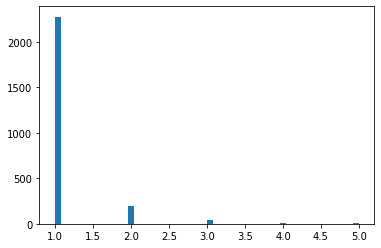

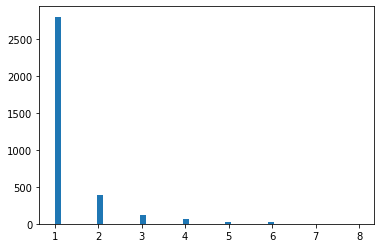

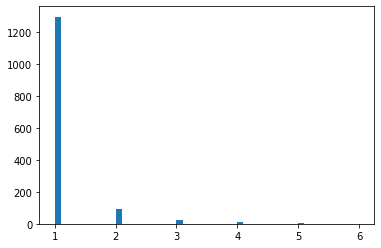

In [8]:
for i in range(10):
  plt.hist(preprocessed_train_df[i][preprocessed_train_df[i]!= 0],bins = 50)
  plt.show()

e) (5 pt.) Explain what is the distribution of the data. Explain what the abundance of zeroes means in this context? Tip: There is an biological explanation.

The data, excluding zeroes, for the 10 first genes follows a Weibull distribution or an exponential distribution when preprocessing is applied.
The abundance of zeroes is caused by the low amount of cells with nuclei from the cells sampled since most blood cells do not contain nuclei. Thus, it won't have DNA and consecutively, any gene in the RNA.



(f) (3 pt.) Access the adata.obs object. Explain what is the information contained
in this data frame. Report the the number of patients, the number of labs, and
the number of cell types in the data.

The dataset contains information about the samples taken such as the origin of the cells, the lab were they were treated, information about the patient etc..

In [9]:
obs_df = pd.DataFrame(train_adata.obs)
print("Number of patients:",len(pd.unique(obs_df['DonorNumber'])))
print("Number of labs:",len(pd.unique(obs_df['Site'])))
print("Number of cell types:", len(pd.unique(obs_df['cell_type'])))
obs_df.head(5)

Number of patients: 9
Number of labs: 4
Number of cell types: 45


,GEX_n_genes_by_counts,GEX_pct_counts_mt,GEX_size_factors,GEX_phase,ADT_n_antibodies_by_counts,ADT_total_counts,ADT_iso_count,cell_type,batch,ADT_pseudotime_order,...,DonorID,DonorAge,DonorBMI,DonorBloodType,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker,is_train
AGTTCCCAGCACCTGC-1-s3d1,948,5.113025,1.371097,G2M,139,2278.0,23.0,CD14+ Mono,s3d1,NaN,...,15078,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker,train
CAGATTGCAAAGGCAC-1-s2d1,2323,4.077203,2.426149,S,91,1190.0,2.0,Erythroblast,s2d1,0.965441,...,15078,34,24.8,B-,White,HISPANIC OR LATINO,Male,False,Nonsmoker,train
GTCATGACAATTTCCT-1-s1d2,1952,7.838442,0.854908,G2M,123,4138.0,14.0,Naive CD20+ B IGKC+,s1d2,NaN,...,10886,35,28.6,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train
TCATCCGCACTTGGCG-1-s2d5,1811,7.071157,1.387475,G2M,105,707.0,2.0,CD14+ Mono,s2d5,NaN,...,16710,40,27.8,O+,White,HISPANIC OR LATINO,Female,False,Smoker,iid_holdout
AGTGCCGGTCATCAGT-1-s2d5,796,4.107981,0.520903,S,96,945.0,4.0,NK,s2d5,NaN,...,16710,40,27.8,O+,White,HISPANIC OR LATINO,Female,False,Smoker,train


###2. Vanilla VAE training
In this task you will adjust the VAE model you implemented during Lab 6 and Lab
7 so that it can be trained on scRNA-seq data. The input to the model (and the
output) should be the gene expression matrix. You need to decide whether you want
to use the raw or the preproccesed matrix (adata.X or adata.layers[’counts’].X).
Note that your VAE should have a stochastic Encoder, Decoder and be trained with
a probabilistic loss.

(a) (10 pt.) Train a VAE model on the data. Verify the training procedure by
showing learning curves for both training and test sets. Reminder: By a learning curve we mean plotting the -ELBO against epoch numbers. Additionally,
break down ELBO into reconstruction and regularization losses and make a
plot accordingly.

For the Base VAE, we will train for 10 epoches, with a latent space dimentionality of 16 and capacity of 32.

In [10]:
#Due to RAM limitations, code cant be run all at once thus will redefine the datasets 
train_adata = sc.read_h5ad("/content/drive/My Drive/project 1/SAD2022Z_Project1_GEX_train.h5ad")
test_adata = sc.read_h5ad("/content/drive/My Drive/project 1/SAD2022Z_Project1_GEX_test.h5ad")
preprocessed_train = train_adata.layers['counts'].toarray()
preprocessed_test = test_adata.layers['counts'].toarray()

In [11]:
i=0
for column in preprocessed_train:
  preprocessed_train[i] = column/max(column)
  i+=1
  
i=0
for column in preprocessed_test:
  preprocessed_test[i] = column/max(column)
  i+=1

In [12]:
train_tensor = torch.from_numpy(preprocessed_train)
train_tensor = torch.reshape(train_tensor, (72208,1,5000))
test_tensor = torch.from_numpy(preprocessed_test)
test_tensor = torch.reshape(test_tensor, (18052,1,5000))

In [13]:
def calculate_output_length(length_in, kernel_size, stride=1, padding=0, dilation=1):
    return (length_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

In [14]:
use_gpu = True
latent_dims = 16
num_epochs = 10
capacity = 32
learning_rate = 2e-5
variational_beta = 10

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        #in : 1 x 5000 x 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=c, kernel_size=20, stride=2, padding=1) # out: c x 2492 x 1 
        self.conv2 = nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=10, stride=2, padding=1) # out: c*2 x 1243 x 1 
        self.conv3 = nn.Conv1d(in_channels=c*2, out_channels=c*2, kernel_size=5, stride=2, padding=1) # out: c*2 x 621 x 1 
        self.fc_mu = nn.Linear(in_features=c*2*621, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*621, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*621)
        self.conv3 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c*2, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=10, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose1d(in_channels=c, out_channels=1, kernel_size=20, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = torch.reshape(x,(capacity*2,621)) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def ELBO_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise cross-entropy.
    # Averaging or not averaging the cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the sequence resolution.
    recon_loss = F.cross_entropy(recon_x, x, reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # and the distribution estimated by the generator for the given sequence.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, variational_beta * kldivergence, recon_loss + (variational_beta * kldivergence)
    
vae16 = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae16 = vae16.to(device)

num_params = sum(p.numel() for p in vae16.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)    

Number of parameters: 2030945


In [16]:
optimizer = torch.optim.Adam(params=vae16.parameters(), lr=learning_rate)

train_loss_avg = []
train_recon_loss_avg = []
train_reg_loss_avg = []

test_loss_avg = []
test_recon_loss_avg = []
test_reg_loss_avg = []

print("Training...")
for epoch in range(num_epochs):
  vae16.train()
  train_loss_avg.append(0)
  train_recon_loss_avg.append(0)
  train_reg_loss_avg.append(0)
  num_batches = 0

  #Subset of samples to train
  permutated_train_tensor =  torch.tensor(np.random.permutation(train_tensor)[:20000])

  for tensor_batch in permutated_train_tensor:

    tensor_batch = tensor_batch.to(device)

    tensor_batch_recon, latent_mu, latent_logvar = vae16(tensor_batch)
    # reconstruction error
    recon_loss,reg_loss, loss = ELBO_loss(tensor_batch_recon, tensor_batch, latent_mu, latent_logvar)
    train_loss_avg[-1] += loss.item()
    train_recon_loss_avg[-1] += recon_loss.item()
    train_reg_loss_avg[-1] += reg_loss.item()

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()
    num_batches += 1

  train_loss_avg[-1] /= num_batches
  train_recon_loss_avg[-1] /= num_batches
  train_reg_loss_avg[-1] /= num_batches
  print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
  
  vae16.eval()
  test_loss_avg.append(0)
  test_recon_loss_avg.append(0)
  test_reg_loss_avg.append(0)
  num_batches = 0
  for tensor_batch in test_tensor:
      with torch.no_grad():
        tensor_batch = tensor_batch.to(device)
        # vae reconstruction
        tensor_batch_recon, latent_mu, latent_logvar = vae16(tensor_batch)
        # reconstruction error
        recon_loss,reg_loss, loss = ELBO_loss(tensor_batch_recon, tensor_batch, latent_mu, latent_logvar)
        test_loss_avg[-1] += loss.item()
        test_recon_loss_avg[-1] += recon_loss.item()
        test_reg_loss_avg[-1] += reg_loss.item()
        num_batches += 1
  
  test_loss_avg[-1] /= num_batches
  test_recon_loss_avg[-1] /= num_batches
  test_reg_loss_avg[-1] /= num_batches
  print('Average test reconstruction error: %f' % (test_loss_avg[-1]))

Training...
Epoch [1 / 10] average reconstruction error: 127.950718
Average test reconstruction error: 125.142589
Epoch [2 / 10] average reconstruction error: 124.490093
Average test reconstruction error: 124.578637
Epoch [3 / 10] average reconstruction error: 125.303788
Average test reconstruction error: 124.374495
Epoch [4 / 10] average reconstruction error: 123.973261
Average test reconstruction error: 124.291932
Epoch [5 / 10] average reconstruction error: 123.892466
Average test reconstruction error: 124.257411
Epoch [6 / 10] average reconstruction error: 123.699236
Average test reconstruction error: 124.232862
Epoch [7 / 10] average reconstruction error: 124.306695
Average test reconstruction error: 124.206438
Epoch [8 / 10] average reconstruction error: 124.137359
Average test reconstruction error: 124.190304
Epoch [9 / 10] average reconstruction error: 124.081011
Average test reconstruction error: 124.184890
Epoch [10 / 10] average reconstruction error: 123.961406
Average test 

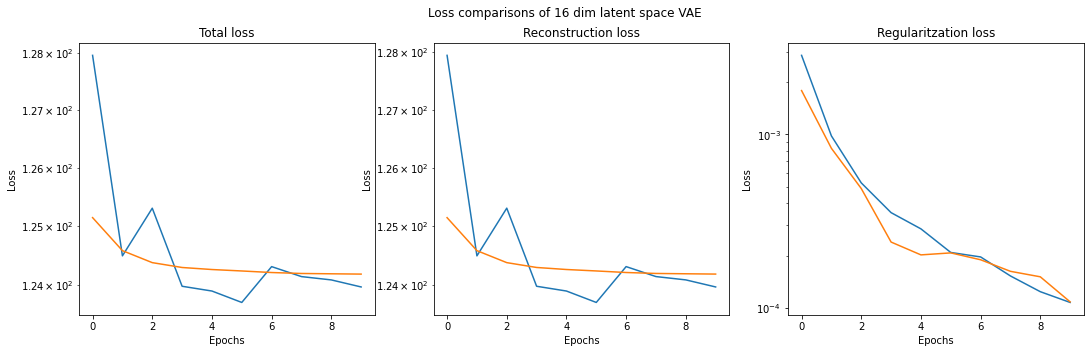

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,5))
fig.suptitle('Loss comparisons of 16 dim latent space VAE')
ax1.plot(train_loss_avg)
ax1.plot(test_loss_avg)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.set_title('Total loss')
ax2.plot(train_recon_loss_avg)
ax2.plot(test_recon_loss_avg)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('Reconstruction loss')
ax3.plot(train_reg_loss_avg)
ax3.plot(test_reg_loss_avg)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_yscale('log')
ax3.set_title('Regularitzation loss')

(b) (10 pt.) Fit a PCA to the latent space. What number of principal components
explains more than 95% of the variance? Show a table in which you choose
three different latent space sizes and report -ELBO on the test set for each of
the models.



In [18]:
def sample_from_latent(mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.empty_like(std).normal_()
    return eps.mul(std).add_(mu)

In [19]:
vae16.eval()
first = True
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      tensor_batch_recon, latent_mu, latent_logvar = vae16(tensor_batch)
      latent_sample = sample_from_latent(latent_mu,latent_logvar).to("cpu").detach().numpy()
      if(first):
        latent_matrix = latent_sample
        first=False
      else:
        latent_matrix = np.vstack((latent_matrix, latent_sample))

var_matrix = np.var(latent_matrix, axis = 0)
norm_var_matrix = np.sort(var_matrix/sum(var_matrix),axis=0)[::-1]

In [20]:
acc_var = 0
n = 0
for element in norm_var_matrix:
  if acc_var < 0.95:
    acc_var+=element
    n+=1

In [21]:
print(str(n)+' Principal components explain '+str(acc_var*100)+'% of the variance')

16 Principal components explain 99.99999590218067% of the variance


Now we will test other latent space sizes, for comparison, we will try 16,32,64.

32 latent space VAE


In [22]:
use_gpu = True
latent_dims = 32
num_epochs = 10
capacity = 32
learning_rate = 2e-5
variational_beta = 10

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        #in : 1 x 5000 x 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=c, kernel_size=20, stride=2, padding=1) # out: c x 2492 x 1 
        self.conv2 = nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=10, stride=2, padding=1) # out: c*2 x 1243 x 1 
        self.conv3 = nn.Conv1d(in_channels=c*2, out_channels=c*2, kernel_size=5, stride=2, padding=1) # out: c*2 x 621 x 1 
        self.fc_mu = nn.Linear(in_features=c*2*621, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*621, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*621)
        self.conv3 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c*2, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=10, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose1d(in_channels=c, out_channels=1, kernel_size=20, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = torch.reshape(x,(capacity*2,621)) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def ELBO_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise cross-entropy.
    # Averaging or not averaging the cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the sequence resolution.
    recon_loss = F.cross_entropy(recon_x, x, reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # and the distribution estimated by the generator for the given sequence.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, variational_beta * kldivergence, recon_loss + (variational_beta * kldivergence)
    
vae32 = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae32 = vae32.to(device)

num_params = sum(p.numel() for p in vae32.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)    

Number of parameters: 3938689


In [24]:
optimizer = torch.optim.Adam(params=vae32.parameters(), lr=learning_rate)

train_loss_avg = []
train_recon_loss_avg = []
train_reg_loss_avg = []

test_loss_avg = []
test_recon_loss_avg = []
test_reg_loss_avg = []

print("Training...")
for epoch in range(num_epochs):
  vae32.train()
  train_loss_avg.append(0)
  train_recon_loss_avg.append(0)
  train_reg_loss_avg.append(0)
  num_batches = 0

  #Subset of samples to train
  permutated_train_tensor =  torch.tensor(np.random.permutation(train_tensor)[:20000])

  for tensor_batch in permutated_train_tensor:

    tensor_batch = tensor_batch.to(device)

    tensor_batch_recon, latent_mu, latent_logvar = vae32(tensor_batch)
    # reconstruction error
    recon_loss,reg_loss, loss = ELBO_loss(tensor_batch_recon, tensor_batch, latent_mu, latent_logvar)
    train_loss_avg[-1] += loss.item()
    train_recon_loss_avg[-1] += recon_loss.item()
    train_reg_loss_avg[-1] += reg_loss.item()

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()
    num_batches += 1

  train_loss_avg[-1] /= num_batches
  train_recon_loss_avg[-1] /= num_batches
  train_reg_loss_avg[-1] /= num_batches
  print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
  
  vae32.eval()
  test_loss_avg.append(0)
  test_recon_loss_avg.append(0)
  test_reg_loss_avg.append(0)
  num_batches = 0
  for tensor_batch in test_tensor:
      with torch.no_grad():
        tensor_batch = tensor_batch.to(device)
        # vae reconstruction
        tensor_batch_recon, latent_mu, latent_logvar = vae32(tensor_batch)
        # reconstruction error
        recon_loss,reg_loss, loss = ELBO_loss(tensor_batch_recon, tensor_batch, latent_mu, latent_logvar)
        test_loss_avg[-1] += loss.item()
        test_recon_loss_avg[-1] += recon_loss.item()
        test_reg_loss_avg[-1] += reg_loss.item()
        num_batches += 1
  
  test_loss_avg[-1] /= num_batches
  test_recon_loss_avg[-1] /= num_batches
  test_reg_loss_avg[-1] /= num_batches
  print('Average test reconstruction error: %f' % (test_loss_avg[-1]))

Training...
Epoch [1 / 10] average reconstruction error: 127.953557
Average test reconstruction error: 125.397109
Epoch [2 / 10] average reconstruction error: 125.681424
Average test reconstruction error: 124.663619
Epoch [3 / 10] average reconstruction error: 124.410428
Average test reconstruction error: 124.429800
Epoch [4 / 10] average reconstruction error: 124.635879
Average test reconstruction error: 124.317827
Epoch [5 / 10] average reconstruction error: 124.803409
Average test reconstruction error: 124.268944
Epoch [6 / 10] average reconstruction error: 124.092011
Average test reconstruction error: 124.238981
Epoch [7 / 10] average reconstruction error: 124.359156
Average test reconstruction error: 124.216804
Epoch [8 / 10] average reconstruction error: 124.032497
Average test reconstruction error: 124.204094
Epoch [9 / 10] average reconstruction error: 124.648425
Average test reconstruction error: 124.194986
Epoch [10 / 10] average reconstruction error: 124.678668
Average test 

Text(0.5, 1.0, 'Regularitzation loss')

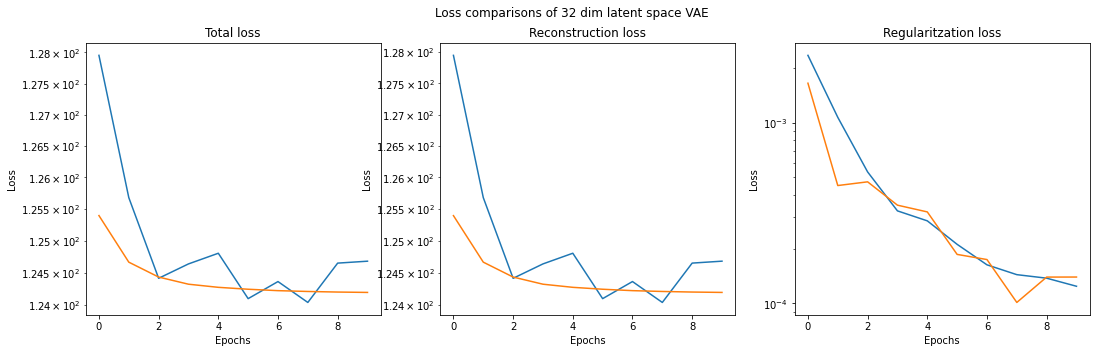

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,5))
fig.suptitle('Loss comparisons of 32 dim latent space VAE')
ax1.plot(train_loss_avg)
ax1.plot(test_loss_avg)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.set_title('Total loss')
ax2.plot(train_recon_loss_avg)
ax2.plot(test_recon_loss_avg)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('Reconstruction loss')
ax3.plot(train_reg_loss_avg)
ax3.plot(test_reg_loss_avg)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_yscale('log')
ax3.set_title('Regularitzation loss')

64 latent space VAE

In [26]:
use_gpu = True
latent_dims = 64
num_epochs = 10
capacity = 32
learning_rate = 2e-5
variational_beta = 10

In [27]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        #in : 1 x 5000 x 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=c, kernel_size=20, stride=2, padding=1) # out: c x 2492 x 1 
        self.conv2 = nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=10, stride=2, padding=1) # out: c*2 x 1243 x 1 
        self.conv3 = nn.Conv1d(in_channels=c*2, out_channels=c*2, kernel_size=5, stride=2, padding=1) # out: c*2 x 621 x 1 
        self.fc_mu = nn.Linear(in_features=c*2*621, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*621, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*621)
        self.conv3 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c*2, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=10, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose1d(in_channels=c, out_channels=1, kernel_size=20, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = torch.reshape(x,(capacity*2,621)) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def ELBO_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise cross-entropy.
    # Averaging or not averaging the cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the sequence resolution.
    recon_loss = F.cross_entropy(recon_x, x, reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # and the distribution estimated by the generator for the given sequence.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, variational_beta * kldivergence, recon_loss + (variational_beta * kldivergence)
    
vae64 = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae64 = vae64.to(device)

num_params = sum(p.numel() for p in vae64.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)    

Number of parameters: 7754177


In [28]:
optimizer = torch.optim.Adam(params=vae64.parameters(), lr=learning_rate)

train_loss_avg = []
train_recon_loss_avg = []
train_reg_loss_avg = []

test_loss_avg = []
test_recon_loss_avg = []
test_reg_loss_avg = []

print("Training...")
for epoch in range(num_epochs):
  vae64.train()
  train_loss_avg.append(0)
  train_recon_loss_avg.append(0)
  train_reg_loss_avg.append(0)
  num_batches = 0

  #Subset of samples to train
  permutated_train_tensor =  torch.tensor(np.random.permutation(train_tensor)[:20000])

  for tensor_batch in permutated_train_tensor:

    tensor_batch = tensor_batch.to(device)

    tensor_batch_recon, latent_mu, latent_logvar = vae64(tensor_batch)
    # reconstruction error
    recon_loss,reg_loss, loss = ELBO_loss(tensor_batch_recon, tensor_batch, latent_mu, latent_logvar)
    train_loss_avg[-1] += loss.item()
    train_recon_loss_avg[-1] += recon_loss.item()
    train_reg_loss_avg[-1] += reg_loss.item()

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()
    num_batches += 1

  train_loss_avg[-1] /= num_batches
  train_recon_loss_avg[-1] /= num_batches
  train_reg_loss_avg[-1] /= num_batches
  print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
  
  vae64.eval()
  test_loss_avg.append(0)
  test_recon_loss_avg.append(0)
  test_reg_loss_avg.append(0)
  num_batches = 0
  for tensor_batch in test_tensor:
      with torch.no_grad():
        tensor_batch = tensor_batch.to(device)
        # vae reconstruction
        tensor_batch_recon, latent_mu, latent_logvar = vae64(tensor_batch)
        # reconstruction error
        recon_loss,reg_loss, loss = ELBO_loss(tensor_batch_recon, tensor_batch, latent_mu, latent_logvar)
        test_loss_avg[-1] += loss.item()
        test_recon_loss_avg[-1] += recon_loss.item()
        test_reg_loss_avg[-1] += reg_loss.item()
        num_batches += 1
  
  test_loss_avg[-1] /= num_batches
  test_recon_loss_avg[-1] /= num_batches
  test_reg_loss_avg[-1] /= num_batches
  print('Average test reconstruction error: %f' % (test_loss_avg[-1]))

Training...
Epoch [1 / 10] average reconstruction error: 128.223475
Average test reconstruction error: 125.428803
Epoch [2 / 10] average reconstruction error: 124.988577
Average test reconstruction error: 124.726800
Epoch [3 / 10] average reconstruction error: 125.079553
Average test reconstruction error: 124.495525
Epoch [4 / 10] average reconstruction error: 124.735298
Average test reconstruction error: 124.390900
Epoch [5 / 10] average reconstruction error: 124.207593
Average test reconstruction error: 124.323716
Epoch [6 / 10] average reconstruction error: 123.885270
Average test reconstruction error: 124.274626
Epoch [7 / 10] average reconstruction error: 124.365619
Average test reconstruction error: 124.246910
Epoch [8 / 10] average reconstruction error: 123.471340
Average test reconstruction error: 124.224946
Epoch [9 / 10] average reconstruction error: 124.268015
Average test reconstruction error: 124.209230
Epoch [10 / 10] average reconstruction error: 123.704564
Average test 

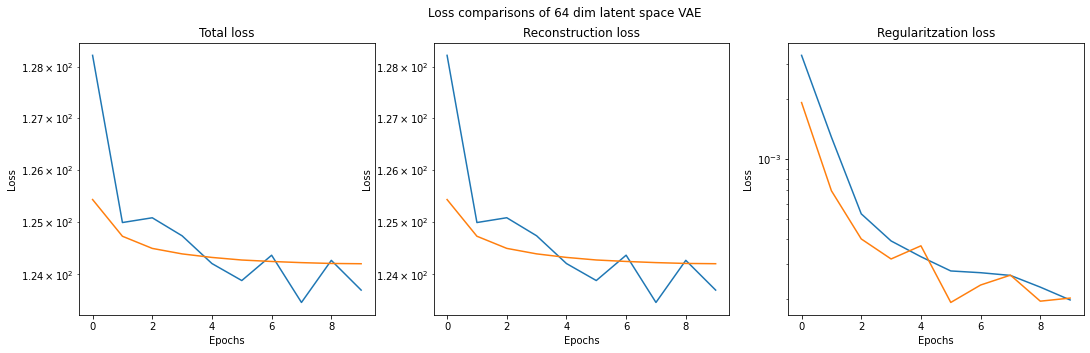

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,5))
fig.suptitle('Loss comparisons of 64 dim latent space VAE')
ax1.plot(train_loss_avg)
ax1.plot(test_loss_avg)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.set_title('Total loss')
ax2.plot(train_recon_loss_avg)
ax2.plot(test_recon_loss_avg)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('Reconstruction loss')
ax3.plot(train_reg_loss_avg)
ax3.plot(test_reg_loss_avg)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_yscale('log')
ax3.set_title('Regularitzation loss')
fig.savefig("final_VAE.png")
fig.show()

So the results of the experiment are as follows

VAE model  | Test total Loss  
-------------------|------------------
16 dim VAE       | 124.179660
32 dim VAE      | 124.189155
64 dim VAE      | 124.203943


In [30]:
def MSE_loss(tensor_batch_recon,tensor_batch):
  loss= F.mse_loss(tensor_batch_recon,tensor_batch)
  return loss

In [31]:
vae16.eval()
test_mse_avg = 0

num_batches = 0
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      # vae reconstruction
      tensor_batch_recon, latent_mu, latent_logvar = vae16(tensor_batch)
      loss = MSE_loss(tensor_batch_recon, tensor_batch)
      loss /= 5000
      test_mse_avg += loss.item()
      num_batches += 1

test_mse_avg /= num_batches
print("Average per gene reconstruction squared error VAE 16:" +str(test_mse_avg))

Average per gene reconstruction squared error VAE 16:2.0004179289263632e-05


In [32]:
vae32.eval()
test_mse_avg = 0

num_batches = 0
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      # vae reconstruction
      tensor_batch_recon, latent_mu, latent_logvar = vae32(tensor_batch)
      loss = MSE_loss(tensor_batch_recon, tensor_batch)
      loss /= 5000
      test_mse_avg += loss.item()
      num_batches += 1

test_mse_avg /= num_batches
print("Average per gene reconstruction squared error VAE 32:" +str(test_mse_avg))

Average per gene reconstruction squared error VAE 32:1.9565918989593662e-05


In [33]:
vae64.eval()
test_mse_avg = 0

num_batches = 0
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      # vae reconstruction
      tensor_batch_recon, latent_mu, latent_logvar = vae64(tensor_batch)
      loss = MSE_loss(tensor_batch_recon, tensor_batch)
      loss /= 5000
      test_mse_avg += loss.item()
      num_batches += 1

test_mse_avg /= num_batches
print("Average per gene reconstruction squared error VAE 64:" +str(test_mse_avg))

Average per gene reconstruction squared error VAE 64:1.940655933798671e-05


(c) (5 pt.) Use a PCA to map all the encoded cells from the test set onto the top
two principal axes and show plots for all models from the previous point. Tip:
If the PCA plot collapses, try subsampling the observations to a smaller number.
Extend the PCA plots by colouring each point with adata.obs.cell type.


In [34]:
vae16.eval()
first = True
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      tensor_batch_recon, latent_mu, latent_logvar = vae16(tensor_batch)
      latent_sample = sample_from_latent(latent_mu,latent_logvar).to("cpu").detach().numpy()
      if(first):
        latent_matrix = latent_sample
        first=False
      else:
        latent_matrix = np.vstack((latent_matrix, latent_sample))

var_matrix = np.var(latent_matrix, axis = 0)
norm_var_matrix = np.sort(var_matrix/sum(var_matrix),axis=0)[::-1]

Text(0.5, 1.0, 'Visual representation of top 2 PCA VAE 16')

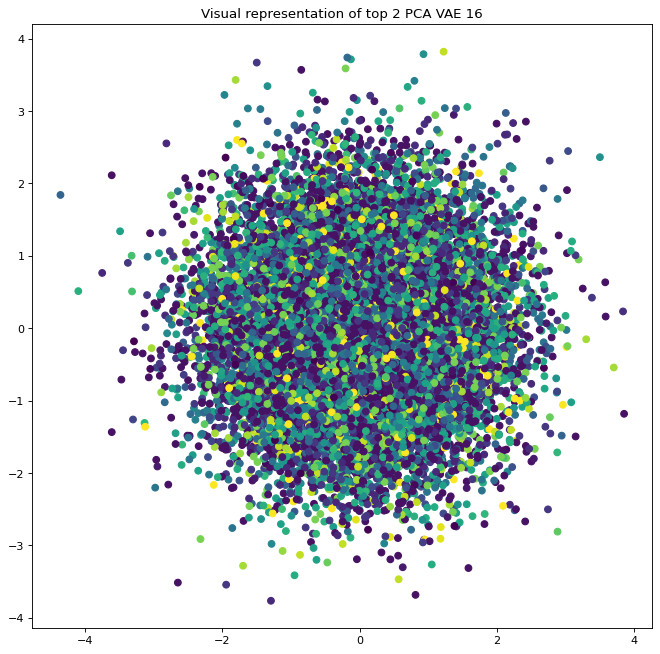

In [35]:
ind = np.argpartition(norm_var_matrix, -2)[-2:] #Get the index of the top 2 principal components
top2 = latent_matrix.T[ind] #Get values of the top 2 principal components
types = list(test_adata.obs.cell_type) #Get cell type
le = preprocessing.LabelEncoder()
types = le.fit_transform(types) #Encode cell type to plot by color
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(top2[0],top2[1], c = types)
plt.title("Visual representation of top 2 PCA VAE 16")

In [36]:
vae32.eval()
first = True
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      tensor_batch_recon, latent_mu, latent_logvar = vae32(tensor_batch)
      latent_sample = sample_from_latent(latent_mu,latent_logvar).to("cpu").detach().numpy()
      if(first):
        latent_matrix = latent_sample
        first=False
      else:
        latent_matrix = np.vstack((latent_matrix, latent_sample))

var_matrix = np.var(latent_matrix, axis = 0)
norm_var_matrix = np.sort(var_matrix/sum(var_matrix),axis=0)[::-1]

Text(0.5, 1.0, 'Visual representation of top 2 PCA VAE 32')

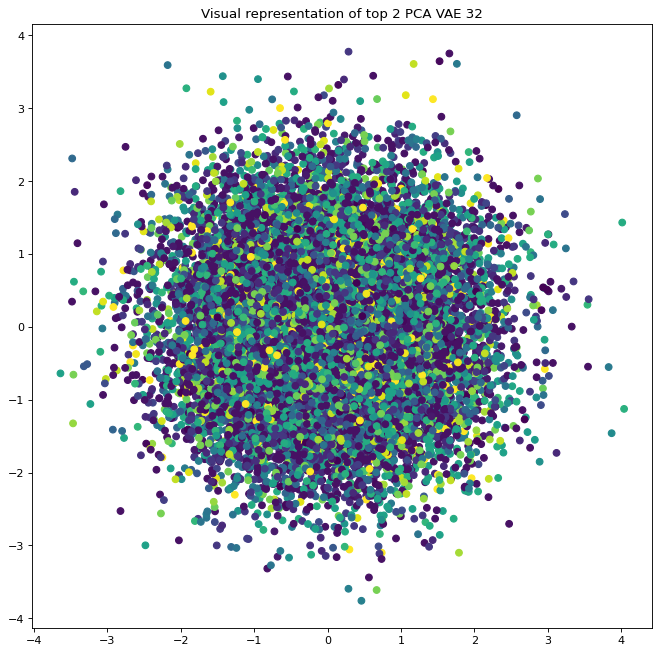

In [37]:
ind = np.argpartition(norm_var_matrix, -2)[-2:] #Get the index of the top 2 principal components
top2 = latent_matrix.T[ind] #Get values of the top 2 principal components
types = list(test_adata.obs.cell_type) #Get cell type
le = preprocessing.LabelEncoder()
types = le.fit_transform(types) #Encode cell type to plot by color
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(top2[0],top2[1], c = types)
plt.title("Visual representation of top 2 PCA VAE 32")

In [38]:
vae64.eval()
first = True
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      tensor_batch_recon, latent_mu, latent_logvar = vae64(tensor_batch)
      latent_sample = sample_from_latent(latent_mu,latent_logvar).to("cpu").detach().numpy()
      if(first):
        latent_matrix = latent_sample
        first=False
      else:
        latent_matrix = np.vstack((latent_matrix, latent_sample))

var_matrix = np.var(latent_matrix, axis = 0)
norm_var_matrix = np.sort(var_matrix/sum(var_matrix),axis=0)[::-1]

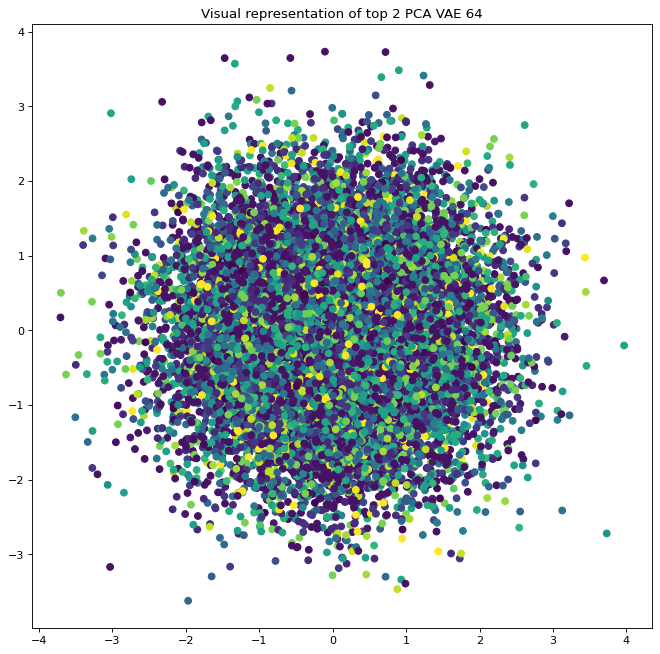

In [39]:
ind = np.argpartition(norm_var_matrix, -2)[-2:] #Get the index of the top 2 principal components
top2 = latent_matrix.T[ind] #Get values of the top 2 principal components
types = list(test_adata.obs.cell_type) #Get cell type
le = preprocessing.LabelEncoder()
types = le.fit_transform(types) #Encode cell type to plot by color
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(top2[0],top2[1], c = types)
plt.title("Visual representation of top 2 PCA VAE 64")
plt.savefig("final_VAE_PCA.png")
plt.show()

(d) (5 pt.) Choose the final model, explain your decision making process behind
choosing the data set (raw or preprocessed) and choosing the size of the latent
space.


After all tests, the best performing model was the VAE with latent space dimensionality of 64, capacity of 32, learning rate of 2e-5 and a variational beta of 10. Since we aren't working with images, we can't really test the reconstruction of the RNA-seq so we took as a reference the MSE for each value of the sequence to find out the best model. As per choosing the data, the preprocessed dataset was much easier to work with since it had discrete values and they were somewhat normalized while keeping the mean close to the raw, thus, in all tests it yield better results.

###3. Custom Decoder
In this task you will modify the Decoder of your VAE to better fit the distribution
of the data.


a) (10 pt.) Using insights from Task 1 Exploration, implement a Decoder that
models the data distributed according to a sensible distribution. Explain you
reasoning behind choosing the Decoder.



Since during task 1, Exploration, we saw that data was distributed exponential-like, a sensible distribution to choose from is from the family of exponentials.

In [40]:
#Due to RAM limitations, code cant be run all at once thus will redefine the datasets 
train_adata = sc.read_h5ad("/content/drive/My Drive/project 1/SAD2022Z_Project1_GEX_train.h5ad")
test_adata = sc.read_h5ad("/content/drive/My Drive/project 1/SAD2022Z_Project1_GEX_test.h5ad")
preprocessed_train = train_adata.layers['counts'].toarray()
preprocessed_test = test_adata.layers['counts'].toarray()

In [41]:
i=0
for column in preprocessed_train:
  preprocessed_train[i] = column/max(column)
  i+=1
  
i=0
for column in preprocessed_test:
  preprocessed_test[i] = column/max(column)
  i+=1

In [42]:
train_tensor = torch.from_numpy(preprocessed_train)
train_tensor = torch.reshape(train_tensor, (72208,1,5000))
test_tensor = torch.from_numpy(preprocessed_test)
test_tensor = torch.reshape(test_tensor, (18052,1,5000))

In [43]:
use_gpu = True
latent_dims = 64
num_epochs = 10
capacity = 32
learning_rate = 2e-5
variational_beta = 10

In [44]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        #in : 1 x 5000 x 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=c, kernel_size=20, stride=2, padding=1) # out: c x 2492 x 1 
        self.conv2 = nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=10, stride=2, padding=1) # out: c*2 x 1243 x 1 
        self.conv3 = nn.Conv1d(in_channels=c*2, out_channels=c*2, kernel_size=5, stride=2, padding=1) # out: c*2 x 621 x 1 
        self.fc_lambda = nn.Linear(in_features=c*2*621, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_lambda = self.fc_lambda(x)
        return x_lambda

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*621)
        self.conv3 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c*2, kernel_size=5, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=10, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose1d(in_channels=c, out_channels=1, kernel_size=20, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = torch.reshape(x,(capacity*2,621)) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_lambda = self.encoder(x)
        latent = self.latent_sample(latent_lambda)
        x_recon = self.decoder(latent)
        return x_recon, latent_lambda
    
    def latent_sample(self, latent_lambda):
        #exponential sampling 
        return torch.empty_like(latent_lambda).exponential_()
    
def ELBO_loss(recon_x, x, latent_lambda):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise cross-entropy.
    # Averaging or not averaging the cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the sequence resolution.
    recon_loss = F.cross_entropy(recon_x, x, reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # and the distribution estimated by the generator for the given sequence.

    #KL divergence with prior as exponential distribution of lambda = 1
    kldivergence = torch.sum(latent_lambda.log( ) + 1/(latent_lambda) - 1)
    return recon_loss, variational_beta * kldivergence, recon_loss + (variational_beta * kldivergence)
    
vae64_e = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae64_e = vae64_e.to(device)

num_params = sum(p.numel() for p in vae64_e.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)    

Number of parameters: 5210497


(b) (20 pt.) Train a VAE with the new Decoder on data selected in the previous
task. Plot learning curves for the new model alongside the final model chosen
in the previous task. Note that here again you need to make an educated guess
on the size of the latent space. Is your new Decoder better?


In [45]:
optimizer = torch.optim.Adam(params=vae64_e.parameters(), lr=learning_rate)

train_loss_avg = []
train_recon_loss_avg = []
train_reg_loss_avg = []

test_loss_avg = []
test_recon_loss_avg = []
test_reg_loss_avg = []

print("Training...")
for epoch in range(num_epochs):
  vae64_e.train()
  train_loss_avg.append(0)
  train_recon_loss_avg.append(0)
  train_reg_loss_avg.append(0)
  num_batches = 0

  #Subset of samples to train
  permutated_train_tensor =  torch.tensor(np.random.permutation(train_tensor)[:20000])#

  for tensor_batch in permutated_train_tensor:

    tensor_batch = tensor_batch.to(device)

    tensor_batch_recon, latent_lambda = vae64_e(tensor_batch)
    # reconstruction error
    recon_loss,reg_loss, loss = ELBO_loss(tensor_batch_recon, tensor_batch, latent_lambda)
    train_loss_avg[-1] += loss.item()
    train_recon_loss_avg[-1] += recon_loss.item()
    train_reg_loss_avg[-1] += reg_loss.item()
                       
    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # one step of the optmizer (using the gradients from backpropagation)
    optimizer.step()
    num_batches += 1

  train_loss_avg[-1] /= num_batches
  train_recon_loss_avg[-1] /= num_batches
  train_reg_loss_avg[-1] /= num_batches
  print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
  
  vae64_e.eval()
  test_loss_avg.append(0)
  test_recon_loss_avg.append(0)
  test_reg_loss_avg.append(0)
  num_batches = 0
  for tensor_batch in test_tensor:
      with torch.no_grad():
        tensor_batch = tensor_batch.to(device)
        # vae reconstruction
        tensor_batch_recon, latent_lambda = vae64_e(tensor_batch)
        # reconstruction error
        recon_loss,reg_loss, loss = ELBO_loss(tensor_batch_recon, tensor_batch, latent_lambda)
        test_loss_avg[-1] += loss.item()
        test_recon_loss_avg[-1] += recon_loss.item()
        test_reg_loss_avg[-1] += reg_loss.item()
        num_batches += 1
  
  test_loss_avg[-1] /= num_batches
  test_recon_loss_avg[-1] /= num_batches
  test_reg_loss_avg[-1] /= num_batches
  print('Average test reconstruction error: %f' % (test_loss_avg[-1]))

Training...
Epoch [1 / 10] average reconstruction error: nan
Average test reconstruction error: 124.162001
Epoch [2 / 10] average reconstruction error: 123.044227
Average test reconstruction error: 124.150978
Epoch [3 / 10] average reconstruction error: 123.205443
Average test reconstruction error: 124.142242
Epoch [4 / 10] average reconstruction error: 123.988039
Average test reconstruction error: 124.129403
Epoch [5 / 10] average reconstruction error: 123.723207
Average test reconstruction error: 124.124479
Epoch [6 / 10] average reconstruction error: 124.663427
Average test reconstruction error: 124.108324
Epoch [7 / 10] average reconstruction error: 123.960495
Average test reconstruction error: 124.106229
Epoch [8 / 10] average reconstruction error: 123.833407
Average test reconstruction error: 124.105245
Epoch [9 / 10] average reconstruction error: 123.692270
Average test reconstruction error: 124.102358
Epoch [10 / 10] average reconstruction error: 123.934480
Average test reconst

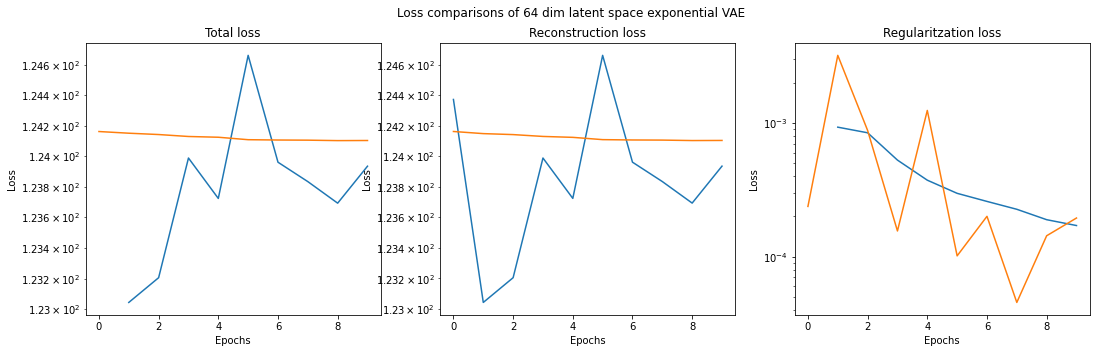

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,5))
fig.suptitle('Loss comparisons of 64 dim latent space exponential VAE')
ax1.plot(train_loss_avg)
ax1.plot(test_loss_avg)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.set_title('Total loss')
ax2.plot(train_recon_loss_avg)
ax2.plot(test_recon_loss_avg)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('Reconstruction loss')
ax3.plot(train_reg_loss_avg)
ax3.plot(test_reg_loss_avg)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_yscale('log')
ax3.set_title('Regularitzation loss')
fig.savefig("exponential_VAE.png")
fig.show()

In [47]:
vae64_e.eval()
test_mse_avg = 0

num_batches = 0
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      # vae reconstruction
      tensor_batch_recon, latent_lambda = vae64_e(tensor_batch)
      loss = MSE_loss(tensor_batch_recon, tensor_batch)
      loss /= 5000
      test_mse_avg += loss.item()
      num_batches += 1

test_mse_avg /= num_batches
print("Average per gene reconstruction squared error exponential VAE 64:" +str(test_mse_avg))

Average per gene reconstruction squared error exponential VAE 64:1.9021845152857234e-05


In [48]:
def sample_from_latent_exp(latent_lambda):
    return torch.empty_like(latent_lambda).exponential_()

In [49]:
vae64_e.eval()
first = True
for tensor_batch in test_tensor:
    with torch.no_grad():
      tensor_batch = tensor_batch.to(device)
      tensor_batch_recon, latent_lambda = vae64_e(tensor_batch)
      latent_sample = sample_from_latent_exp(latent_lambda).to("cpu").detach().numpy()
      if(first):
        latent_matrix = latent_sample
        first=False
      else:
        latent_matrix = np.vstack((latent_matrix, latent_sample))

var_matrix = np.var(latent_matrix, axis = 0)
norm_var_matrix = np.sort(var_matrix/sum(var_matrix),axis=0)[::-1]

In [50]:
acc_var = 0
n = 0
for element in norm_var_matrix:
  if acc_var < 0.95:
    acc_var+=element
    n+=1

In [51]:
print(str(n)+' Principal components explain '+str(acc_var*100)+'% of the variance')

61 Principal components explain 95.48929817974567% of the variance


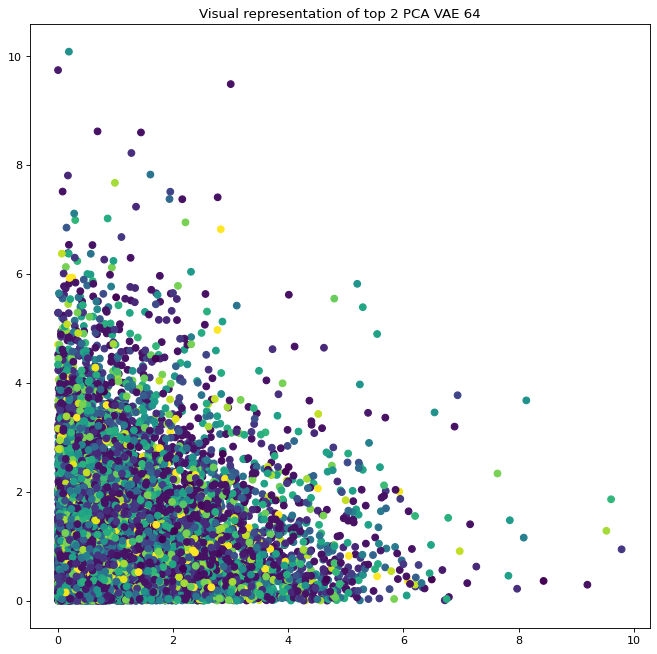

In [52]:
ind = np.argpartition(norm_var_matrix, -2)[-2:] #Get the index of the top 2 principal components
top2 = latent_matrix.T[ind] #Get values of the top 2 principal components
types = list(test_adata.obs.cell_type) #Get cell type
le = preprocessing.LabelEncoder()
types = le.fit_transform(types) #Encode cell type to plot by color
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(top2[0],top2[1], c = types)
plt.title("Visual representation of top 2 PCA VAE 64")
plt.savefig("exponential_VAE_PCA.png")
plt.show()

Now lets compare the new decoder with the best one of last task

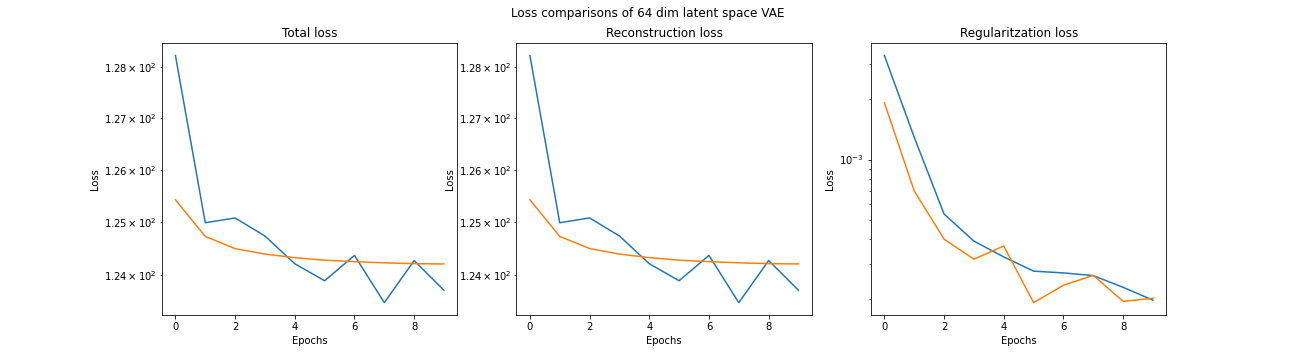

In [53]:
Image('final_VAE.png')

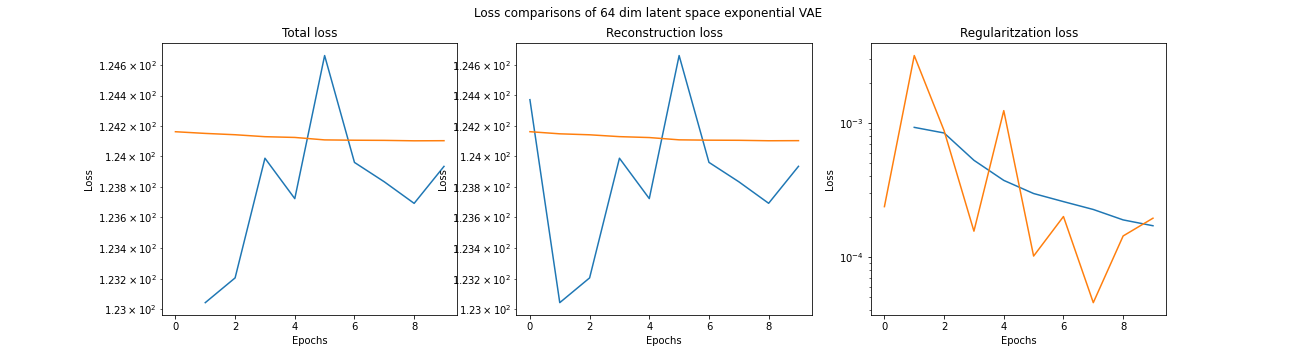

In [54]:
Image('exponential_VAE.png')

We see that the new decoder works better on the test subset. Also, the average per gene MSE is lower.

(c) (5 pt.) Plot the latent space of your final model from this task and from the
previous task using PCA, as done in the previous exercise. Compare the plots.
Explain whether you see any differences.



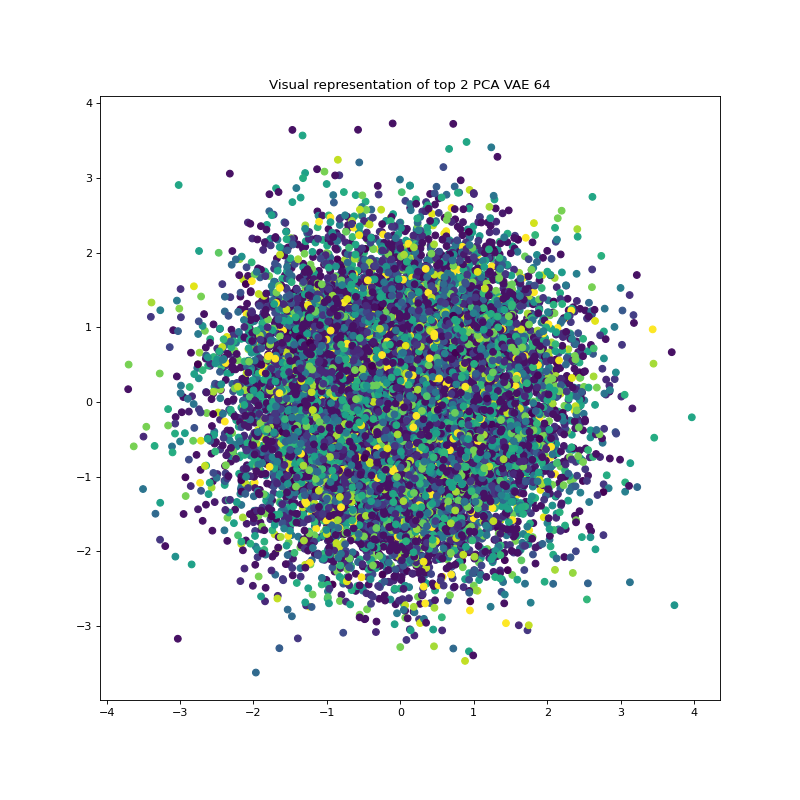

In [55]:
Image("final_VAE_PCA.png") 

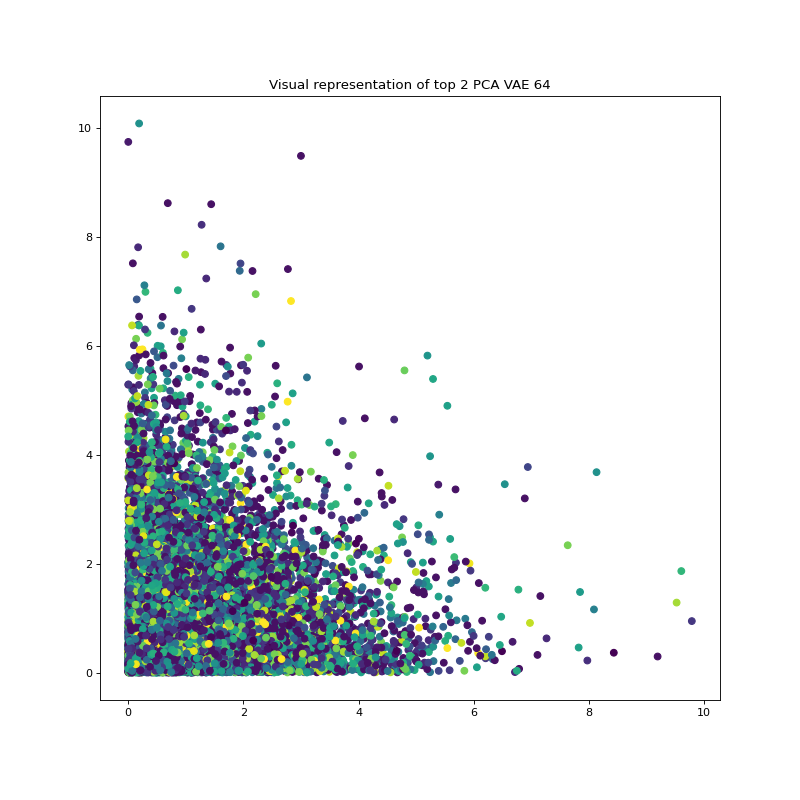

In [56]:
Image("exponential_VAE_PCA.png") 

Since the samples are taken from different distributions, they have different shapes. We still can't really see any clustering of types of cells in either of the top 2 PCA plots.